<a href="https://colab.research.google.com/github/hiswordsini/AI_Bootcamp_Project/blob/main/Section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **로딩**

In [ ]:
#pip install pandas

In [ ]:
#!pip install pdpbox

In [ ]:
#!pip install shap

In [ ]:
#pip install -U pandas-profiling

In [ ]:
#pip install category_encoders

     |████████████████████████████████| 81kB 5.3MB/s 


In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
import pandas as pd
from pandas import Series,DataFrame
import pandas_profiling
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, MinMaxScaler #,OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, classification_report, plot_confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pdpbox import pdp, get_dataset, info_plots
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.inspection import partial_dependence, plot_partial_dependence
from category_encoders import OrdinalEncoder


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists
#HR Analytics: Job Change of Data Scientists


train = pd.read_csv('/content/gdrive/MyDrive/Kaggle/DS_Job_Change/aug_train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Kaggle/DS_Job_Change/aug_test.csv')

#**초기 탐색**

In [ ]:
train.shape, test.shape

((19158, 14), (2129, 13))

In [ ]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

*   ID와 타겟을 제외하고 2가지 특성만 수치형이고 나머지는 모두 범주형 특성이다. 이 중에서 last_new_job와 experience 같은 특성은 수치형으로 변환 할 것이다. 그래서 총 4가지 수치형 특성이 있는 자료가 될 것이다.

In [ ]:
train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

*   절반 이상의 특성들이 결측치를 포함하고 있음을 알 수 있다. 각각의 컬럼을 분석하면서 처리해 나갈 것이다.

In [ ]:
train.target.value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

In [ ]:
train.target.value_counts(normalize=True)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64



*   데이터가 불균형임을 알 수 있다.
*   데이터 불균형 문제 부터 처리할 것이다.



*   target 0: 직장을 옮기지 않는다와 target 1:직장을 옮긴다 간의 차이가 많은 불균형 데이터 셋이므로 데이터가 적은 target 1의 데이터를 늘리는 업샘플링으로 데이터셋의 균형을 맞춰 볼 것입니다.

 

* 그전에 데이터 Leakage 방지를 위해 훈련세트와 검증 세트로 먼저 데이터를 나눈 후 업샘플링을 할 것입니다. 


In [ ]:
train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape

((15326, 14), (3832, 14))

훈련 데이터와 검증 데이터에 대해서 업샘플링을 합니다.

In [ ]:
#타겟 다수와 소수로 훈련과 검증 세트를 나눕니다.
train_majority = train[train.target == 0]
train_minority = train[train.target == 1]
val_majority = val[val.target == 0]
val_minority = val[val.target == 1]
train_majority.shape, train_minority.shape, val_majority.shape, val_minority.shape

((11513, 14), (3813, 14), (2868, 14), (964, 14))

In [ ]:
# Resample function을 사용하여 minority dataframe의 갯수를 majority dataframe의 데이터 갯수만큼 증가시킵니다.
train_minority_upsampled = resample(train_minority, replace=True, n_samples=train_majority.shape[0], random_state=123)
val_minority_upsampled = resample(val_minority, replace=True, n_samples=val_majority.shape[0], random_state=123)
train_minority_upsampled.shape, val_minority_upsampled.shape

((11513, 14), (2868, 14))

In [ ]:
# 증가시킨 minority dataframe과 majority dataframe을 다시 합쳐줍니다.
train_upsampled = pd.concat([train_majority, train_minority_upsampled])
val_upsampled = pd.concat([val_majority, val_minority_upsampled])
train_upsampled.shape, val_upsampled.shape

((23026, 14), (5736, 14))

In [ ]:
train_upsampled.profile_report()

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]



* city 특성이 122개의 범주로 High Cardinality 임을 알 수 있다.


# **범주형 변수(Categorical Variables)**

**City**

In [ ]:
train_upsampled['city'].value_counts()

city_103    4889
city_21     4657
city_16     1508
city_114    1294
city_160    1026
            ... 
city_31        3
city_129       3
city_25        2
city_121       2
city_171       1
Name: city, Length: 122, dtype: int64

*   122개의 서로 다른 도시들이 있다.

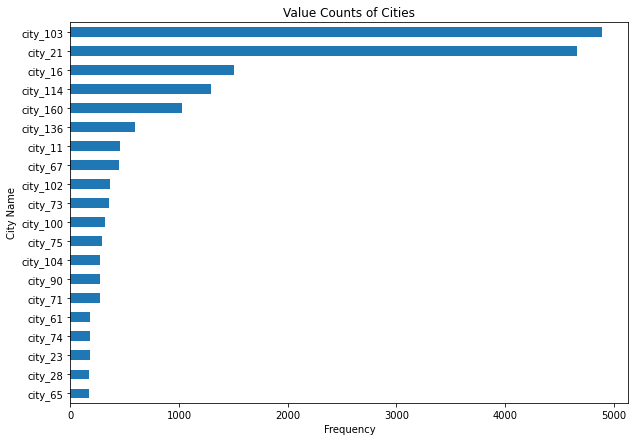

In [ ]:
plt.figure(figsize=(10,7))

train_upsampled['city'].value_counts()[:20].sort_values(ascending=True).plot(kind='barh')
plt.title('Value Counts of Cities')
plt.xlabel('Frequency')
plt.ylabel('City Name');



*   상위 20개의 도시 리스트이다. 
*   도시들이 익명화되어 정확히 어느 도시인지를 알 수 없어 중요하지 않고 High Cardinality 특성이므로 이 특성은 빼기로 한다. 


**Gender**

In [ ]:
train_upsampled['gender'].value_counts()

Male      15550
Female     1467
Other       231
Name: gender, dtype: int64

In [ ]:
train_upsampled['gender'].isnull().sum()

5778

In [ ]:
train_upsampled['gender'].fillna('Unknown', inplace=True)
val_upsampled['gender'].fillna('Unknown', inplace=True)
test['gender'].fillna('Unknown', inplace=True)



*   결측치는 'Unknown'이라는 값을 주기로 한다.



In [ ]:
train_upsampled[train_upsampled['gender'] == 'Unknown']

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
2935,189,city_71,0.884,Unknown,Has relevent experience,Part time course,Masters,STEM,13,500-999,Pvt Ltd,1,40,0.0
17164,9109,city_91,0.691,Unknown,Has relevent experience,no_enrollment,Graduate,Other,6,10/49,Funded Startup,1,78,0.0
11097,14780,city_40,0.776,Unknown,No relevent experience,no_enrollment,Masters,STEM,16,50-99,Pvt Ltd,never,59,0.0
10846,5794,city_16,0.910,Unknown,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,12,0.0
14002,28511,city_16,0.910,Unknown,Has relevent experience,no_enrollment,Graduate,STEM,10,10/49,Pvt Ltd,4,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2406,12043,city_50,0.896,Unknown,No relevent experience,Full time course,Graduate,STEM,3,NaN,NaN,never,35,1.0
1438,16653,city_70,0.698,Unknown,Has relevent experience,no_enrollment,Graduate,STEM,2,1000-4999,Other,1,140,1.0
7709,21810,city_21,0.624,Unknown,No relevent experience,Full time course,Graduate,STEM,<1,NaN,NaN,never,50,1.0
5229,26983,city_103,0.920,Unknown,Has relevent experience,no_enrollment,Graduate,STEM,6,10000+,Pvt Ltd,1,78,1.0




*   인사이트를 도출하기 위해 Unknown 값으로 된 컬럼들을 확인한다.
*   별다른 특이사항이 발견되지 않는다.



데이터를 시각화 해본다

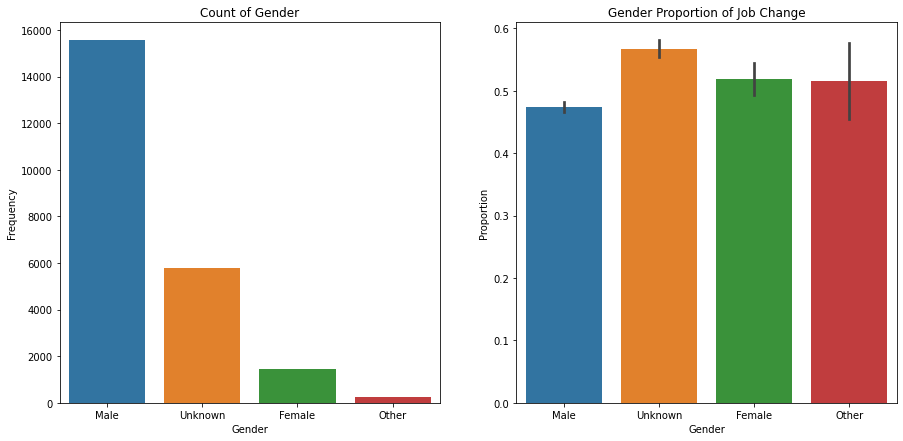

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='gender')
plt.title('Count of Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency');

plt.subplot(122)
sns.barplot(data=train_upsampled, x='gender', y='target')
plt.title('Gender Proportion of Job Change')
plt.xlabel('Gender')
plt.ylabel('Proportion');



*   데이터의 수에는 남자가 현저히 많음을 알 수 있다.
*   이직을 하는 성별의 비율은 Unknown이 가장 많고 여자와 그외의 성별이 비슷하고 남자가 상대적으로 비율이 작다.



좀 더 자세히 들여다 보자

성별과 타겟의 개수를 비교하는 테이블을 만든다

In [ ]:
gender_table = pd.crosstab(train_upsampled['gender'], train_upsampled['target'])
gender_table

target,0.0,1.0
gender,,
Female,707,760
Male,8194,7356
Other,112,119
Unknown,2500,3278




*   남자가 여자 보다 열배 넘게 데이터를 차지하고 있다.



각 성별별로 이직하는 비율을 나타낸 테이블을 만들어본다.

In [ ]:
pd.crosstab(train_upsampled['gender'], train_upsampled['target'], normalize='index')

target,0.0,1.0
gender,,
Female,0.481936,0.518064
Male,0.526945,0.473055
Other,0.484848,0.515152
Unknown,0.432676,0.567324




*   여자가 남자보다 이직하는 비율이 더 많음을 알 수 있다.
*   결측(Unknown) 데이터에서 이직하는 비율이 가장 많이 나타났음을 알 수 있다



성별이 이직 여부를 예측하는 특성으로 사용될지 판가름하기 위해 통계적 유의미함을 알아볼 수 있는 카이 제곱 테스트를 해본다.

In [ ]:
stat, p, dof, expected = chi2_contingency(gender_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 9.546110020821455e-33
Dependent (reject H0)




*   p value 가 0.05 보다 현저히 작으므로 귀무 가설을 기각한다. (성별과 타겟 값 사이의 관계는 독립적이지 않다.(종속적이다))
*   성별과 타겟 값 사이에 유의미한 종속 관계가 있음을 의미하므로 이 특성을 모델을 만드는데 사용하기로 한다.


**Relevant Experience**

In [ ]:
train_upsampled['relevent_experience'].value_counts()

Has relevent experience    15779
No relevent experience      7247
Name: relevent_experience, dtype: int64

* 관련 경험이 있는 경우가 없는 경우의 두배를 넘는다. 



간단하게 바꾸고 인코딩을 위해서 Has relevant experience 를 1로 바꾸고 No relevant experience를 0으로 바꾼다.

In [ ]:
train_upsampled['relevent_experience'] = train_upsampled['relevent_experience'].replace('Has relevent experience', 1)
train_upsampled['relevent_experience'] = train_upsampled['relevent_experience'].replace('No relevent experience', 0)
val_upsampled['relevent_experience'] = val_upsampled['relevent_experience'].replace('Has relevent experience', 1)
val_upsampled['relevent_experience'] = val_upsampled['relevent_experience'].replace('No relevent experience', 0)
test['relevent_experience'] = test['relevent_experience'].replace('Has relevent experience', 1)
test['relevent_experience'] = test['relevent_experience'].replace('No relevent experience', 0)

비율과 개수를 시각화 한다.

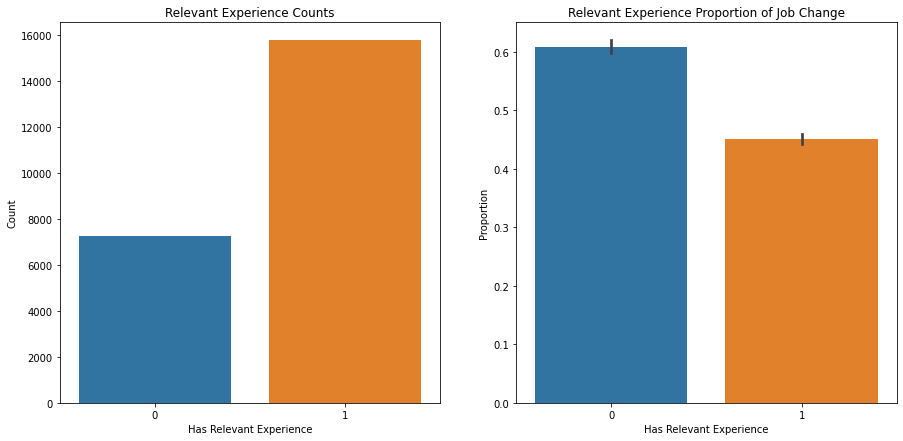

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='relevent_experience')
plt.title('Relevant Experience Counts')
plt.xlabel('Has Relevant Experience')
plt.ylabel('Count');

plt.subplot(122)
sns.barplot(data=train_upsampled, x='relevent_experience', y='target')
plt.title('Relevant Experience Proportion of Job Change')
plt.xlabel('Has Relevant Experience')
plt.ylabel('Proportion');



*   관련 경험이 있는 사람이 없는 사람의 2배 이상이다
*   이직 여부는 관련 경험이 없는 사람이 더 많다는 것을 알 수 있다.



이 차이를 분명히 하기 위해 카이 제곱 테스트를 한다

In [ ]:
exp_table = pd.crosstab(train_upsampled['relevent_experience'], train_upsampled['target'])
exp_table

target,0.0,1.0
relevent_experience,,
0,2839,4408
1,8674,7105


In [ ]:
pd.crosstab(train_upsampled['relevent_experience'], train_upsampled['target'], normalize = 'index')

target,0.0,1.0
relevent_experience,,
0,0.391748,0.608252
1,0.549718,0.450282


In [ ]:
stat, p, dof, expected = chi2_contingency(exp_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 1.1196808673160488e-109
Dependent (reject H0)




*   p value가 0.05 보다 현저히 작음을 알 수 있다. 따라서 relevent experience도 모델에 추가하기 좋은 특성으로 생각된다.



**Enrolled University**


*   Enrolled University는 지원자가 대학에 풀타임으로 등록되어 있는지 아니면 파트 타임으로 등록되어 있는지 아니면 등록되어 있지 않은지 나타낸다

In [ ]:
train_upsampled['enrolled_university'].value_counts()

no_enrollment       15766
Full time course     5350
Part time course     1397
Name: enrolled_university, dtype: int64



*   대부분의 사람들이 대학에 등록되어 있지 않다




In [ ]:
train_upsampled['enrolled_university'].isnull().sum()

513

결측치를 'Unknown'으로 채우기로 한다.

In [ ]:
train_upsampled['enrolled_university'].fillna('Unknown', inplace=True)
val_upsampled['enrolled_university'].fillna('Unknown', inplace=True)
test['enrolled_university'].fillna('Unknown', inplace=True)

In [ ]:
train_upsampled['enrolled_university'].value_counts()

no_enrollment       15766
Full time course     5350
Part time course     1397
Unknown               513
Name: enrolled_university, dtype: int64

시각화 한다

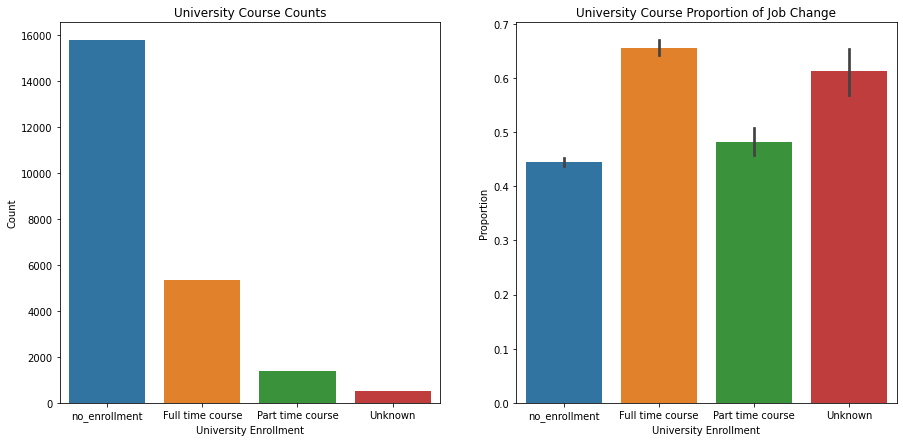

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='enrolled_university')
plt.title('University Course Counts')
plt.xlabel('University Enrollment')
plt.ylabel('Count');


plt.subplot(122)
sns.barplot(data=train_upsampled, x='enrolled_university', y='target')
plt.title('University Course Proportion of Job Change')
plt.xlabel('University Enrollment')
plt.ylabel('Proportion');



*   대부분의 사람들이 대학에 등록되어 있지 않고 그러한 사람들이 이직 비율이 가장 작았다.
*   풀 타임으로 대학에 등록되어 있는 사람들이 이직 비율이 가장 많았고 그 다음이 결측 데이터의 사람들이었다.



카이 제곱 테스트를 한다.

In [ ]:
enrolled_table = pd.crosstab(train_upsampled['enrolled_university'],train_upsampled['target'])
pd.crosstab(train_upsampled['enrolled_university'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
enrolled_university,,
Full time course,0.344673,0.655327
Part time course,0.518253,0.481747
Unknown,0.387914,0.612086
no_enrollment,0.554738,0.445262


In [ ]:
stat, p, dof, expected = chi2_contingency(enrolled_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 1.537606806946799e-158
Dependent (reject H0)




*   University Enrollment 도 모델에 포함할 좋은 특성이다.


**Education Level**

학력은 (Ph.D, Masters, Graduate, HIgh School, Primary School) 값으로 구분된다.

In [ ]:
train_upsampled['education_level'].value_counts()

Graduate          14367
Masters            5088
High School        2280
Phd                 441
Primary School      310
Name: education_level, dtype: int64



*   대부분의 사람들이 대졸(Graduate)이다.



In [ ]:
train_upsampled['education_level'].isnull().sum()

540

결측치를 'Unknown'으로 대체한다.

In [ ]:
train_upsampled['education_level'].fillna('Unknown', inplace=True)
val_upsampled['education_level'].fillna('Unknown', inplace=True)
test['education_level'].fillna('Unknown', inplace=True)

In [ ]:
train_upsampled['education_level'].value_counts()

Graduate          14367
Masters            5088
High School        2280
Unknown             540
Phd                 441
Primary School      310
Name: education_level, dtype: int64

시각화 한다.

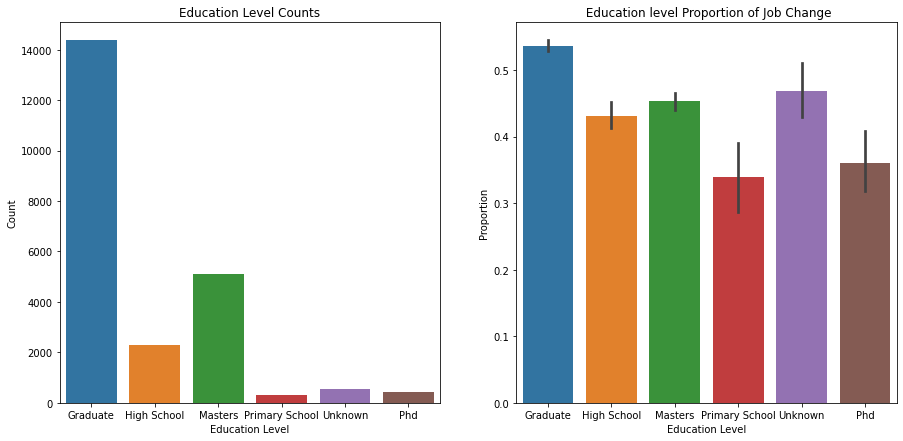

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='education_level')
plt.title('Education Level Counts')
plt.xlabel('Education Level')
plt.ylabel('Count');


plt.subplot(122)
sns.barplot(data=train_upsampled, x='education_level', y='target')
plt.title(' Education level Proportion of Job Change')
plt.xlabel('Education Level')
plt.ylabel('Proportion');



*   대졸자는 다른 학력을 모두 합친 것보다 월등히 많으나 이직 비율에서는 다른 학력에 비해 약간 높은 비율을 보임을 알 수 있다.



In [ ]:
edu_table = pd.crosstab(train_upsampled['education_level'],train_upsampled['target'])

In [ ]:
pd.crosstab(train_upsampled['education_level'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
education_level,,
Graduate,0.463423,0.536577
High School,0.568860,0.431140
Masters,0.547170,0.452830
Phd,0.639456,0.360544
Primary School,0.661290,0.338710
Unknown,0.531481,0.468519


카이 제곱 테스트

In [ ]:
stat, p, dof, expected = chi2_contingency(edu_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 1.4021315190662944e-48
Dependent (reject H0)




*   Education Level도 모델에 포함한다.

**Major Discipline**

전공계열은 (STEM, Humanities, Other, Business Degree, Arts, No Major)로 구분된다.

In [ ]:
train_upsampled['major_discipline'].value_counts()

STEM               17669
Humanities           743
Other                467
Business Degree      387
Arts                 316
No Major             267
Name: major_discipline, dtype: int64



*   전공은 STEM(과학,기술,공학,수학)이 월등히 많은 수를 차지함을 알 수 있다.



In [ ]:
train_upsampled['major_discipline'].isnull().sum()

3177

결측 데이터는 'Unknown'으로 채운다.

In [ ]:
train_upsampled['major_discipline'].fillna('Unknown', inplace=True)
val_upsampled['major_discipline'].fillna('Unknown', inplace=True)
test['major_discipline'].fillna('Unknown', inplace=True)

시각화

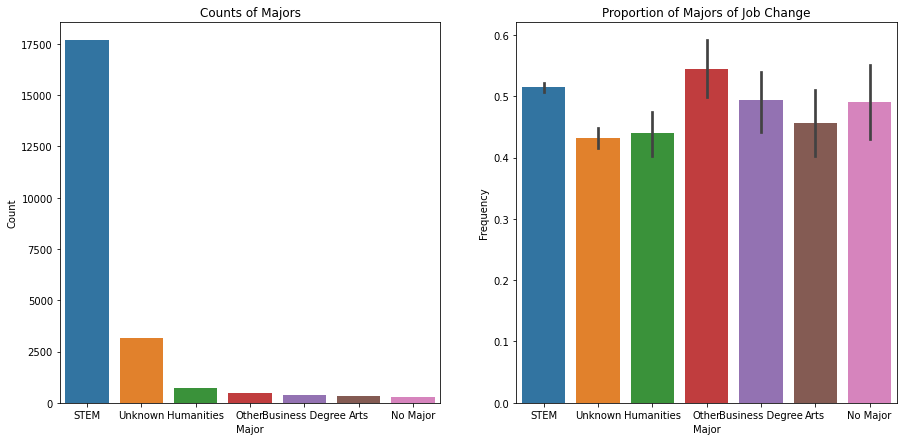

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, x='major_discipline')
plt.title('Counts of Majors')
plt.xlabel('Major')
plt.ylabel('Count');

plt.subplot(122)
sns.barplot(data=train_upsampled, x='major_discipline', y='target')
plt.title('Proportion of Majors of Job Change')
plt.xlabel('Major')
plt.ylabel('Frequency');



*   STEM degree가 숫자면에서는 월등히 많음을 알 수 있다.
*   이직 비율은 전공 계열들이 비슷비슷 함을 알 수 있다.



In [ ]:
major_table = pd.crosstab(train_upsampled['major_discipline'],train_upsampled['target'])

In [ ]:
pd.crosstab(train_upsampled['major_discipline'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
major_discipline,,
Arts,0.544304,0.455696
Business Degree,0.506460,0.493540
Humanities,0.559892,0.440108
No Major,0.509363,0.490637
Other,0.456103,0.543897
STEM,0.485257,0.514743
Unknown,0.568461,0.431539


카이 제곱 테스트

In [ ]:
stat, p, dof, expected = chi2_contingency(major_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 1.2664591955662902e-17
Dependent (reject H0)



*   Major Discipline 특성도 모델에 포함한다.


**Company Size**

회사 규모는 (<10, 10/49, 50-99, 100-500, 500-999, 1000-4999, 5000-9999, 10000+) 의 값을 가진다

In [ ]:
train_upsampled['company_size'].value_counts()

50-99        3357
100-500      2657
10000+       2231
10/49        1737
<10          1395
1000-4999    1379
500-999       944
5000-9999     598
Name: company_size, dtype: int64



*   50-99명의 규모가 가장 많다.



In [ ]:
train_upsampled['company_size'].isnull().sum()

8728

결측치를 'Unknown'으로 대체한다.

In [ ]:
train_upsampled['company_size'].fillna('Unknown', inplace=True)
val_upsampled['company_size'].fillna('Unknown', inplace=True)
test['company_size'].fillna('Unknown', inplace=True)

시각화

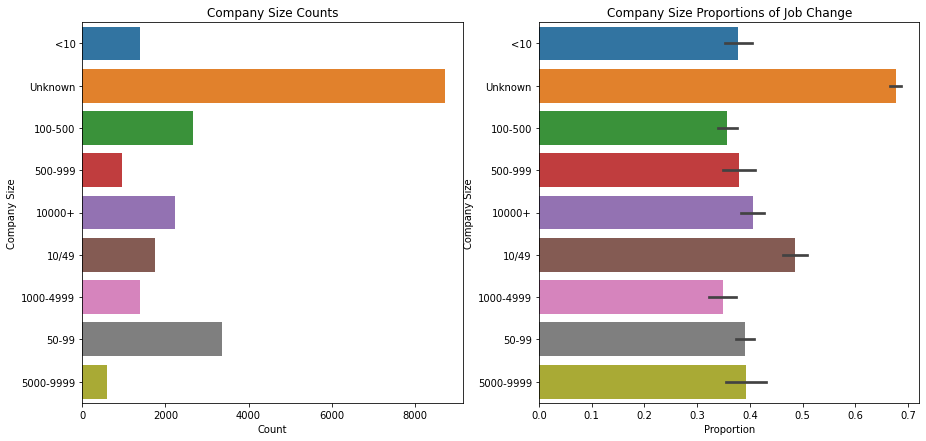

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, y='company_size')
plt.title('Company Size Counts')
plt.xlabel('Count')
plt.ylabel('Company Size');

plt.subplot(122)
sns.barplot(data=train_upsampled, y='company_size', x='target')
plt.title('Company Size Proportions of Job Change')
plt.xlabel('Proportion')
plt.ylabel('Company Size');



*   결측 데이터의 사람들이 가장 많음을 알 수 있다.
*   이직 비율도 결측 데이터의 사람들이 가장 많음을 알 수 있다.



In [ ]:
comp_size_table = pd.crosstab(train_upsampled['company_size'],train_upsampled['target'])
pd.crosstab(train_upsampled['company_size'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
company_size,,
10/49,0.514105,0.485895
100-500,0.643583,0.356417
1000-4999,0.651922,0.348078
10000+,0.594801,0.405199
50-99,0.609771,0.390229
500-999,0.620763,0.379237
5000-9999,0.607023,0.392977
<10,0.622222,0.377778
Unknown,0.323098,0.676902


카이 제곱 테스트

In [ ]:
stat, p, dof, expected = chi2_contingency(comp_size_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 0.0
Dependent (reject H0)




*   Company Size도 모델에 포함한다.



**Company Type**

회사 타입은 (Pvt Ltd, Funded Startup, Public Sector, Early Stage Startup, NGO, Other)의 값을 가진다.

In [ ]:
train_upsampled['company_type'].value_counts()

Pvt Ltd                10695
Public Sector           1094
Funded Startup           999
Early Stage Startup      737
NGO                      555
Other                    155
Name: company_type, dtype: int64



*   개인 회사가 가장 많음을 알 수 있다.



In [ ]:
train_upsampled['company_type'].isnull().sum()

8791

결측치를 'Unknown'으로 대체한다.

In [ ]:
train_upsampled['company_type'].fillna('Unknown', inplace=True)
val_upsampled['company_type'].fillna('Unknown', inplace=True)
test['company_type'].fillna('Unknown', inplace=True)

시각화

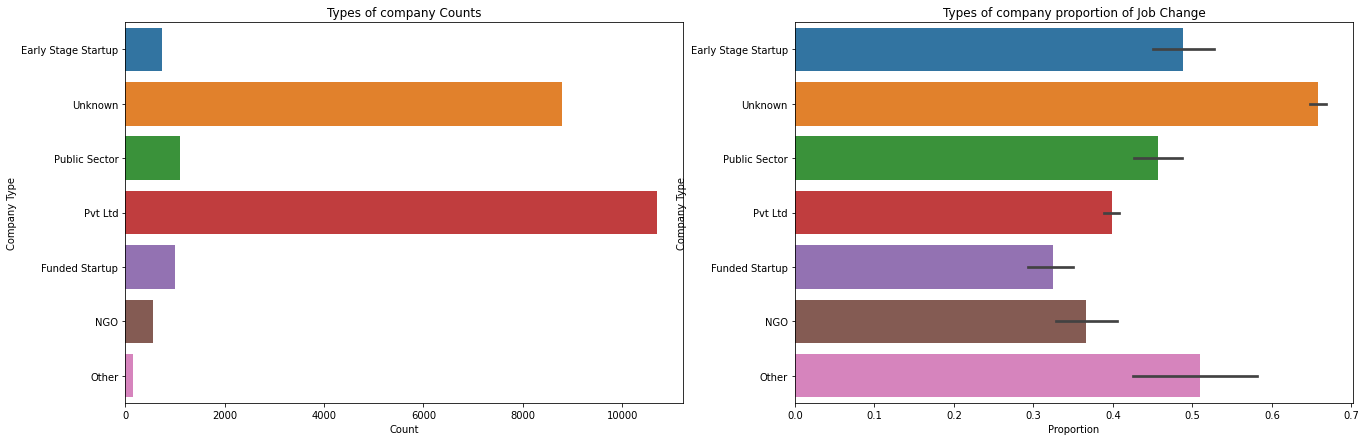

In [ ]:
plt.figure(figsize=(22,7))

plt.subplot(121)
sns.countplot(data=train_upsampled, y='company_type')
plt.title('Types of company Counts')
plt.xlabel('Count')
plt.ylabel('Company Type');

plt.subplot(122)
sns.barplot(data=train_upsampled, y='company_type', x='target')
plt.title('Types of company proportion of Job Change')
plt.xlabel('Proportion')
plt.ylabel('Company Type');



*   개인회사(Pvt Ltd)가 가장 많은 수를 차지하고 그 다음 결측 데이터의 회사들이 많음을 알 수 있다.
*   이직 비율은 결측 데이터의 회사들이 가장 많음을 알 수 있다.



In [ ]:
comp_type_table = pd.crosstab(train_upsampled['company_type'],train_upsampled['target'])
pd.crosstab(train_upsampled['company_type'],train_upsampled['target'], normalize = 'index')

target,0.0,1.0
company_type,,
Early Stage Startup,0.511533,0.488467
Funded Startup,0.675676,0.324324
NGO,0.634234,0.365766
Other,0.490323,0.509677
Public Sector,0.543876,0.456124
Pvt Ltd,0.601122,0.398878
Unknown,0.342282,0.657718


카이 제곱 테스트

In [ ]:
stat, p, dof, expected = chi2_contingency(comp_type_table)

# interpret p-value 
alpha = 0.05
print("p value is " + str(p)) 
if p <= alpha: 
    print('Dependent (reject H0)') 
else: 
    print('Independent (H0 holds true)') 

p value is 0.0
Dependent (reject H0)




*   Company Type도 모델에 포함한다.


# **연속형 변수(Continuous Variables)**

**City Development Index**

In [ ]:
train_upsampled['city_development_index'].describe()

count    23026.000000
mean         0.804492
std          0.134329
min          0.448000
25%          0.624000
50%          0.890000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

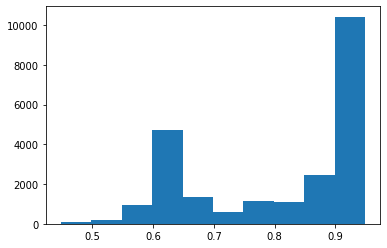

In [ ]:
plt.hist(data=train_upsampled, x='city_development_index');



*   대부분의 도시개발지수가 0.9보다 높다



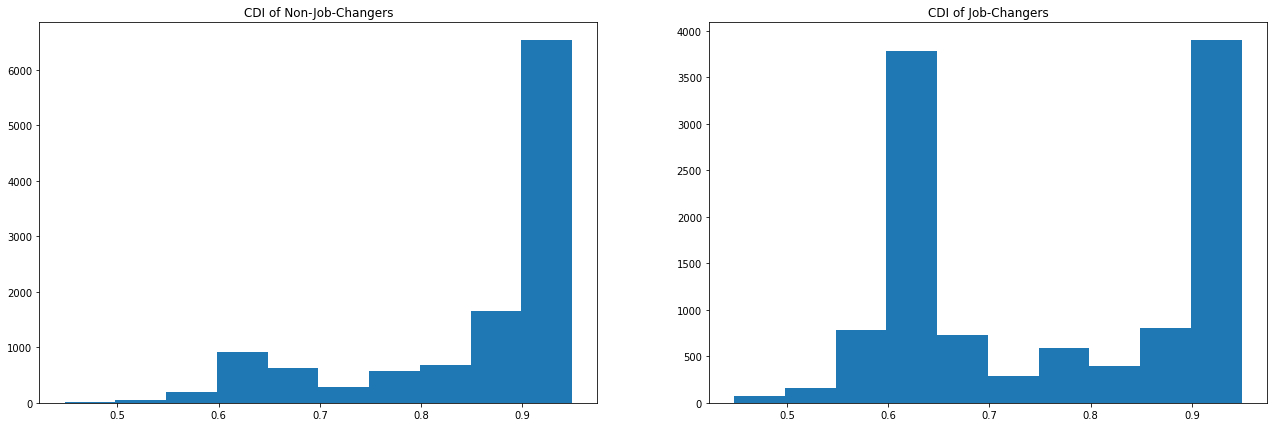

In [ ]:
plt.figure(figsize=(22,7))

plt.subplot(121)
plt.title('CDI of Non-Job-Changers')
plt.hist(data=train_upsampled[train_upsampled['target'] == 0], x='city_development_index')


plt.subplot(122)
plt.title('CDI of Job-Changers')
plt.hist(data=train_upsampled[train_upsampled['target'] == 1], x='city_development_index');



*   이직을 하지 않는 쪽은 도시개발지수가 전체 분포와 비슷하다.
*   이직을 하는 쪽은 도시개발지수가 0.6과 0.9 주위에서 많은 수를 기록했다.



<AxesSubplot:xlabel='target', ylabel='city_development_index'>

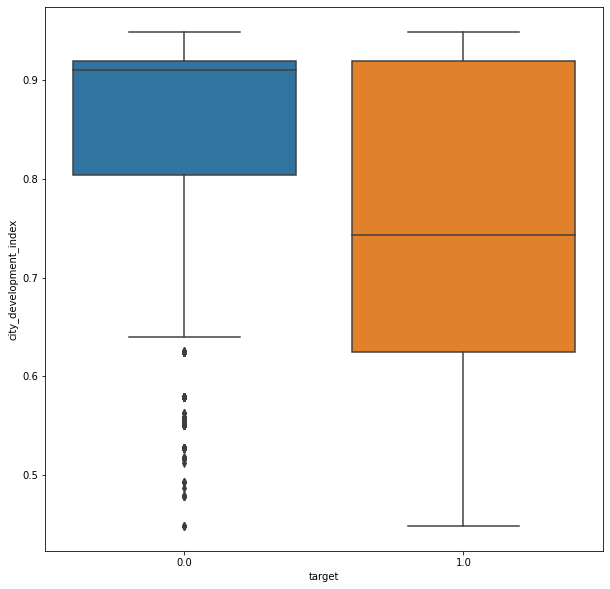

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=train_upsampled, x='target', y='city_development_index')

Kruskal Wallis Test

두 그룹 사이에 통계적으로 유의미한 차이가 있는지 알아보기 위해 연속형 변수(Continuous Variable)에 사용되는 Kruskal Wallis Test를 시행해 본다.

In [ ]:
no_change_df = train_upsampled[train_upsampled['target'] == 0]
change_df =  train_upsampled[train_upsampled['target'] == 1]

In [ ]:
stats.kruskal(no_change_df['city_development_index'], change_df['city_development_index'])

KruskalResult(statistic=2378.1398154123535, pvalue=0.0)

*   p value 가 0으로 매우 작다. 통계적으로 매우 유의미한 특성으로 모델에 포함한다.

**Experience**

경험은 년수를 나타낸 것으로 1 보다 작거나 부터 20보다 큰 값까지 있다.

In [ ]:
train_upsampled['experience'].value_counts()

>20    3457
4      1846
5      1800
3      1795
6      1550
2      1522
7      1292
9      1151
10     1132
8       913
1       894
11      781
<1      736
15      730
14      687
16      551
12      531
13      465
17      360
19      303
18      279
20      180
Name: experience, dtype: int64

'>20'을 21로 <1을 0으로 바꾼다. 이렇게 하여 일관된 데이터 타입을 갖고 모델이 읽어 들일 수 있는 값을 갖게 된다.

In [ ]:
train_upsampled['experience'].isnull().sum()

71

결측치는 데이터에서 랜덤하게 뽑아서 채우도록 한다.


In [ ]:
np.random.seed(123) #랜덤한 값이 매번 같은 값을 가지도록 랜덤 씨드를 지정해준다.
train_upsampled['experience'] = train_upsampled['experience'].replace('>20', 21)
train_upsampled['experience'] = train_upsampled['experience'].replace('<1', 0)
train_upsampled['experience'] = train_upsampled['experience'].fillna(np.random.choice(train_upsampled['experience']))
val_upsampled['experience'] = val_upsampled['experience'].replace('>20', 21)
val_upsampled['experience'] = val_upsampled['experience'].replace('<1', 0)
val_upsampled['experience'] = val_upsampled['experience'].fillna(np.random.choice(val_upsampled['experience']))
test['experience'] = test['experience'].replace('>20', 21)
test['experience'] = test['experience'].replace('<1', 0)
test['experience'] = test['experience'].fillna(np.random.choice(test['experience']))

In [ ]:
(test['experience'].unique()), (train_upsampled['experience'].unique()), (val_upsampled['experience'].unique())

(array(['9', '5', 0, '11', 21, '10', '14', '3', '20', '8', '4', '13', '2',
        '6', '7', '1', '19', '15', '16', '17', '18', '12'], dtype=object),
 array(['2', '7', '6', '13', 21, 0, '16', '8', '10', '3', '12', '9', '4',
        '14', '5', '15', '19', '17', '11', '1', '18', '20'], dtype=object),
 array([21, '5', '8', '7', 0, '6', '11', '10', '1', '14', '4', '15', '3',
        '18', '17', '19', '16', '2', '9', '12', '13', '20'], dtype=object))

수치형 데이터 타입이 되도록 데이터 타임을 float로 바꾼다.

In [ ]:
train_upsampled['experience'] = train_upsampled['experience'].astype('float64')
val_upsampled['experience'] = val_upsampled['experience'].astype('float64')
test['experience'] = test['experience'].astype('float64')

데이터를 살펴본다

In [ ]:
train_upsampled['experience'].describe()

count    23026.000000
mean         9.415704
std          6.692446
min          0.000000
25%          4.000000
50%          8.000000
75%         15.000000
max         21.000000
Name: experience, dtype: float64

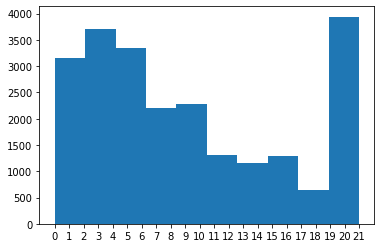

In [ ]:
plt.xticks(np.arange(0, 22))
plt.hist(data=train_upsampled, x='experience');



*   20년 이상과 0~6년 사이의 경험이 가장 많음을 알 수 있다.



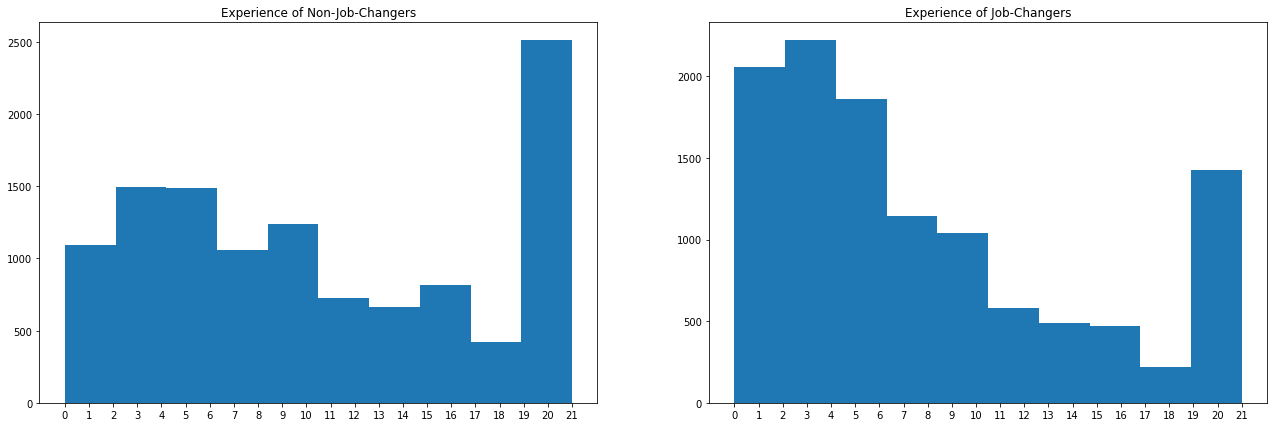

In [ ]:
plt.figure(figsize=(22,7))

plt.subplot(121)
plt.title('Experience of Non-Job-Changers')
plt.xticks(np.arange(0, 22))
plt.hist(data=train_upsampled[train_upsampled['target'] == 0], x='experience')

plt.subplot(122)
plt.title('Experience of Job-Changers')
plt.xticks(np.arange(0, 22))
plt.hist(data=train_upsampled[train_upsampled['target'] == 1], x='experience');



*   이직자들 중 0~6년사이의 경험자가 가장 많고 그리고 20년 이상이 많다.
*   비이직자들중에서는 20년 이상이 가장 많음을 알 수 있다.



<AxesSubplot:xlabel='target', ylabel='experience'>

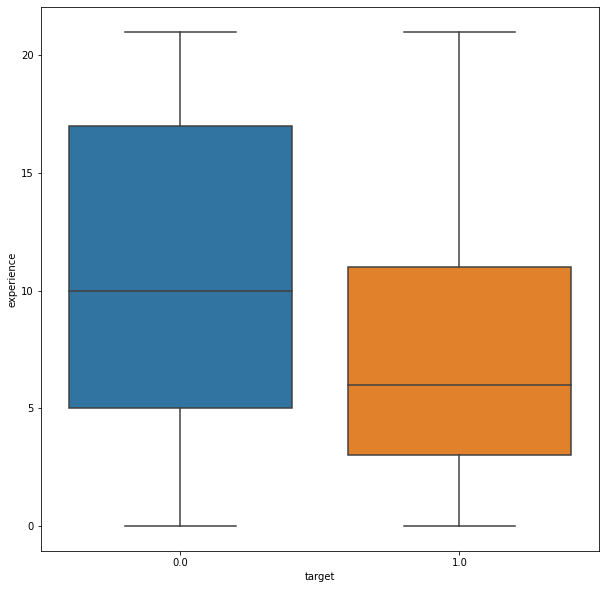

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=train_upsampled, x='target', y='experience')



*   경험이 적을 수록 이직할 확률이 높은듯하다.



Kruskal Wallis Test

In [ ]:
no_change_df = train_upsampled[train_upsampled['target'] == 0]
change_df =  train_upsampled[train_upsampled['target'] == 1]

stats.kruskal(no_change_df['experience'], change_df['experience'])

KruskalResult(statistic=996.7544855279108, pvalue=9.11433322223398e-219)

*   p-value가 매우 낮으므로 통계적으로 유의미한 특성임을 알 수 있다. Experience도 모델에 포함한다.

**Last New Job**

이전 직장과 현재 직장 사이의 년수의 차를 나타낸다.

In [ ]:
train_upsampled['last_new_job'].value_counts()

1        9892
>4       3589
2        3442
never    3139
4        1210
3        1200
Name: last_new_job, dtype: int64



*   never을 0으로 >4 를 5로 바꾼다.
*   결측치는 데이터에서 랜덤하게 뽑아내어 채운다.
*   수치형 데이터가 되도록 데이터 타입을 float으로 바꾼다.




In [ ]:
train_upsampled['last_new_job'] = train_upsampled['last_new_job'].replace('>4', 5)
train_upsampled['last_new_job'] = train_upsampled['last_new_job'].replace('never', 0)
train_upsampled['last_new_job'] = train_upsampled['last_new_job'].fillna(np.random.choice(train_upsampled['last_new_job']))
train_upsampled['last_new_job'] = train_upsampled['last_new_job'].astype('float64')
val_upsampled['last_new_job'] = val_upsampled['last_new_job'].replace('>4', 5)
val_upsampled['last_new_job'] = val_upsampled['last_new_job'].replace('never', 0)
val_upsampled['last_new_job'] = val_upsampled['last_new_job'].fillna(np.random.choice(val_upsampled['last_new_job']))
val_upsampled['last_new_job'] = val_upsampled['last_new_job'].astype('float64')
test['last_new_job'] = test['last_new_job'].replace('>4', 5)
test['last_new_job'] = test['last_new_job'].replace('never', 0)
test['last_new_job'] = test['last_new_job'].fillna(np.random.choice(test['last_new_job']))
test['last_new_job'] = test['last_new_job'].astype('float64')


데이터 클린 후 시각화한다.

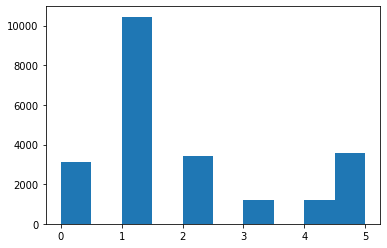

In [ ]:
plt.hist(data=train_upsampled, x='last_new_job');



*   대부분의 데이터가 전 직장 사이의 간격이 1년이다.



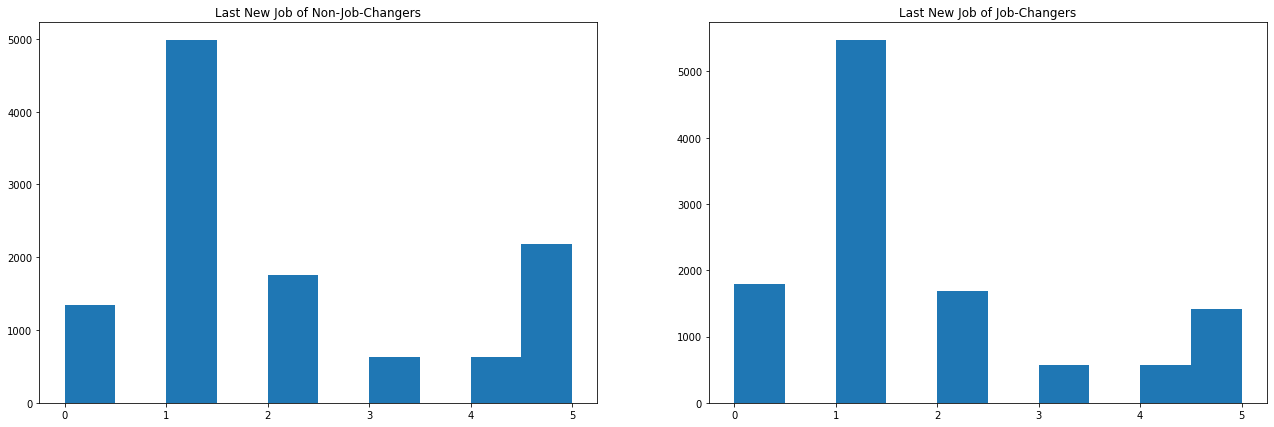

In [ ]:
plt.figure(figsize=(22,7))

plt.subplot(121)
plt.title("Last New Job of Non-Job-Changers")
plt.hist(data=train_upsampled[train_upsampled['target'] == 0], x='last_new_job')

plt.subplot(122)
plt.title("Last New Job of Job-Changers")
plt.hist(data=train_upsampled[train_upsampled['target'] == 1], x='last_new_job');



*   이직자와 비이직자들의 분포가 비슷하다.



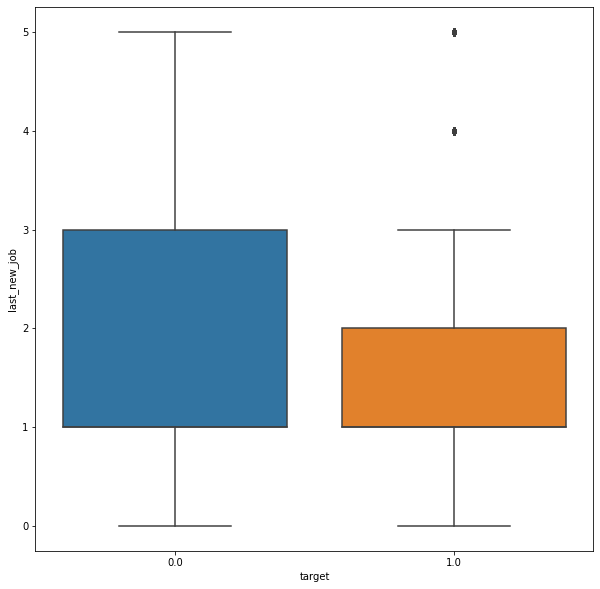

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=train_upsampled, x='target', y='last_new_job');



*   이직자들은 주로 지난 직장과의 년수차가 적은 듯하다. 오랜 년수차를 가진 사람일수록 직장을 바꾸려 하지 않으려 하는 것일 수 있다.



Kruskal Wallis Test



In [ ]:
no_change_df = train_upsampled[train_upsampled['target'] == 0]
change_df =  train_upsampled[train_upsampled['target'] == 1]

stats.kruskal(no_change_df['last_new_job'], change_df['last_new_job'])

KruskalResult(statistic=226.47713712156207, pvalue=3.496596559147369e-51)



*   p value가 0.05 보다 현저히 작다. 통계적으로 유의미하므로 이 특성도 모델에서 사용한다.



**training_hours**

직원의 현재 포지션을 위한 훈련 시간을 나타낸다.

In [ ]:
train_upsampled['training_hours'].describe()

count    23026.000000
mean        64.697342
std         59.515442
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64

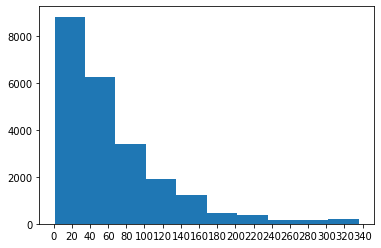

In [ ]:
plt.xticks(np.arange(0,350,20))
plt.hist(data=train_upsampled, x='training_hours');



*   중위 값이 47이고 대부분의 값이 0~60시간 사이에 있다.



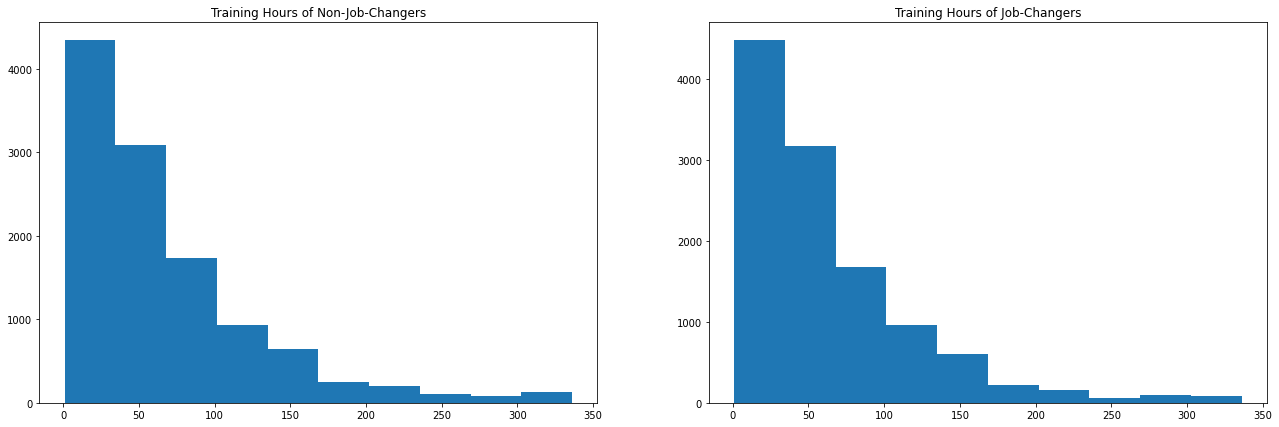

In [ ]:
plt.figure(figsize=(22,7))

plt.subplot(121)
plt.title('Training Hours of Non-Job-Changers')
plt.hist(data=train_upsampled[train_upsampled['target'] == 0], x='training_hours')

plt.subplot(122)
plt.title('Training Hours of Job-Changers')
plt.hist(data=train_upsampled[train_upsampled['target'] == 1], x='training_hours');



*   이직자와 비이직자 사이에 분포의 차이가 거의 없어 보인다.



<AxesSubplot:xlabel='target', ylabel='training_hours'>

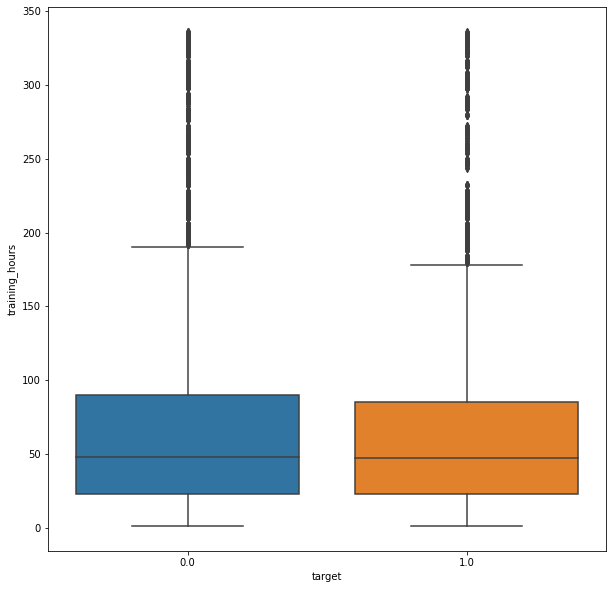

In [ ]:
plt.figure(figsize=(10,10))
sns.boxplot(data=train_upsampled, x='target', y='training_hours')



*   박스 플롯도 분포가 비슷하다.



Kruskal Wallis Test

In [ ]:
no_change_df = train_upsampled[train_upsampled['target'] == 0]
change_df =  train_upsampled[train_upsampled['target'] == 1]

stats.kruskal(no_change_df['training_hours'], change_df['training_hours'])

KruskalResult(statistic=6.667459350421786, pvalue=0.009818906248216762)

*   p value가 여태까지 특성 중 가장 크나 그래도 0.05 보다 작으므로 통계적으로 유의미하다고 본다. 이 특성도 모델에 사용한다. 

# **모델링(Modelling)**

X_train, X_val, X_test, y_train, y_val, y_test를 만든다.

In [ ]:
#enrollee_id, city, target 컬럼을 제외한 모든 컬럼을 X_train,X_val,X_test에 배정하고 y_train, y_val에는 target 값을 넣어준다.
X_train = train_upsampled[['city_development_index','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job','training_hours']]
y_train = train_upsampled['target']
X_val = val_upsampled[['city_development_index','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job','training_hours']]
y_val = val_upsampled['target']
X_test = test[['city_development_index','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job','training_hours']]

In [ ]:
#y_test 값을 데이터에서 불러온다
y_test = np.load('/content/gdrive/MyDrive/Kaggle/DS_Job_Change/jobchange_test_target_values.npy', encoding='bytes')

**베이스 라인 모델**(평가지표 = accuracy, precision, recall, RUC curve, AUC score)

분류 문제에서 베이스 라인 모델은 타겟 변수의 최빈값으로 모든 데이터를 예측하는 것이다. 

In [ ]:
#mode()[0] returns highest frequency value
major = y_train.mode()[0]
y_pred = [major] * len(y_train) #y_train 데이터 개수만큼 0으로 채운다.(예측값)

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     11513
         1.0       0.00      0.00      0.00     11513

    accuracy                           0.50     23026
   macro avg       0.25      0.50      0.33     23026
weighted avg       0.25      0.50      0.33     23026



AUC score:  0.5


Text(0, 0.5, 'TPR')

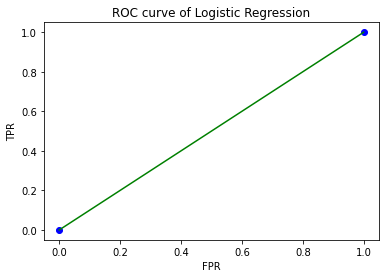

In [ ]:
y_pred_proba = [0] * len(y_val) #0으로만 예측하므로 1을 예측할 확률은 0이다.
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve of Logistic Regression')
plt.xlabel('FPR')
plt.ylabel('TPR')

* 정확도:0.50, 정밀도:0.50,0.00, 재현율: 1.00,0.00, AUC:0.5


(array([8818., 6261., 3414., 1890., 1247.,  475.,  361.,  169.,  177.,
         214.]),
 array([  1. ,  34.5,  68. , 101.5, 135. , 168.5, 202. , 235.5, 269. ,
        302.5, 336. ]),
 <BarContainer object of 10 artists>)

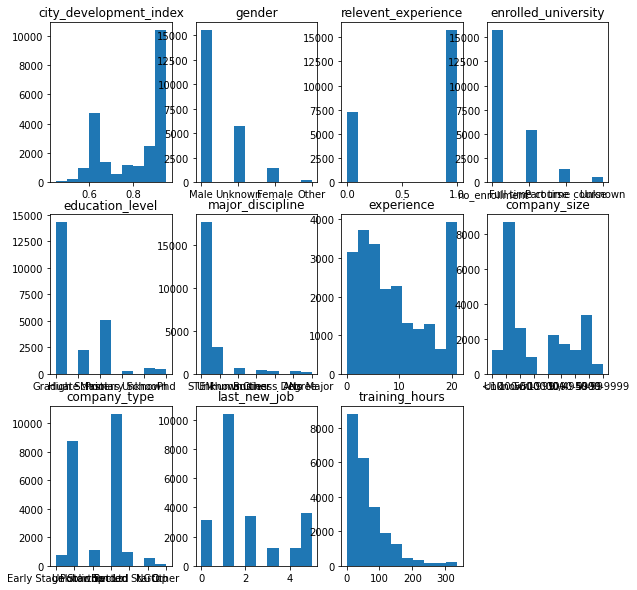

In [ ]:
#히스토그램을 통해 데이터의 분포를 그려본다.
plt.figure(figsize=(10,10))
plt.subplot(341)
plt.title('city_development_index')
plt.hist(data=X_train, x='city_development_index')

plt.subplot(342)
plt.title('gender')
plt.hist(data=X_train, x='gender');

plt.subplot(343)
plt.title('relevent_experience')
plt.hist(data=X_train, x='relevent_experience')

plt.subplot(344)
plt.title('enrolled_university')
plt.hist(data=X_train, x='enrolled_university')

plt.subplot(345)
plt.title('education_level')
plt.hist(data=X_train, x='education_level')

plt.subplot(346)
plt.title('major_discipline')
plt.hist(data=X_train, x='major_discipline')

plt.subplot(347)
plt.title('experience')
plt.hist(data=X_train, x='experience')

plt.subplot(348)
plt.title('company_size')
plt.hist(data=X_train, x='company_size')

plt.subplot(349)
plt.title('company_type')
plt.hist(data=X_train, x='company_type')

plt.subplot(3,4,10)
plt.title('last_new_job')
plt.hist(data=X_train, x='last_new_job')

plt.subplot(3,4,11)
plt.title('training_hours')
plt.hist(data=X_train, x='training_hours')


*   Histogram을 보면 각 특성들이 정규분포를 띄지 않음을 알 수 있다.
*   Logistic Regression을 위해 MinMaxScaler을 사용하는 것이 좋겠다.

**Logistic Regression**(Linear Model)

In [ ]:
pipe = make_pipeline(
    OrdinalEncoder(),
    MinMaxScaler(), 
    LogisticRegression()
)
pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.7133891213389121


인코딩이 잘 된건지 알고 싶다.

In [ ]:
pipe.steps

[('ordinalencoder',
  OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)),
 ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('logisticregression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False))]

In [ ]:
pipe[0].categories_

[array([0.448, 0.479, 0.487, 0.493, 0.512, 0.516, 0.518, 0.527, 0.55 ,
        0.555, 0.556, 0.558, 0.563, 0.579, 0.624, 0.625, 0.64 , 0.645,
        0.647, 0.649, 0.664, 0.666, 0.68 , 0.682, 0.689, 0.691, 0.693,
        0.698, 0.701, 0.722, 0.725, 0.727, 0.73 , 0.735, 0.738, 0.739,
        0.74 , 0.742, 0.743, 0.745, 0.754, 0.762, 0.763, 0.764, 0.766,
        0.767, 0.769, 0.775, 0.776, 0.78 , 0.781, 0.788, 0.789, 0.794,
        0.795, 0.796, 0.802, 0.804, 0.807, 0.824, 0.827, 0.83 , 0.836,
        0.84 , 0.843, 0.847, 0.848, 0.855, 0.856, 0.865, 0.866, 0.878,
        0.884, 0.887, 0.89 , 0.893, 0.895, 0.896, 0.897, 0.898, 0.899,
        0.903, 0.91 , 0.913, 0.915, 0.92 , 0.921, 0.923, 0.924, 0.925,
        0.926, 0.939, 0.949]),
 array(['Female', 'Male', 'Other', 'Unknown'], dtype=object),
 array([0, 1]),
 array(['Full time course', 'Part time course', 'Unknown', 'no_enrollment'],
       dtype=object),
 array(['Graduate', 'High School', 'Masters', 'Phd', 'Primary School',
        'Un

In [ ]:
bother = pipe.named_steps['ordinalencoder']
X_train_enc = bother.fit_transform(X_train)
bother.mapping

AttributeError: ignored

*   Ordinal Encoding이 잘 된 것을 볼 수 있다. 

Text(0.5, 1.0, 'Confusion matrix, n = 5736')

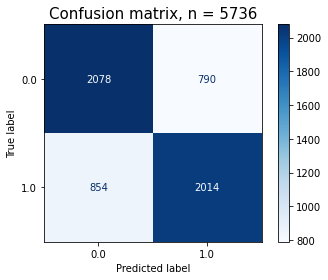

In [ ]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            values_format='d',
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

In [ ]:
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72      2868
         1.0       0.72      0.70      0.71      2868

    accuracy                           0.71      5736
   macro avg       0.71      0.71      0.71      5736
weighted avg       0.71      0.71      0.71      5736



AUC score:  0.7628675433631141


Text(0, 0.5, 'TPR')

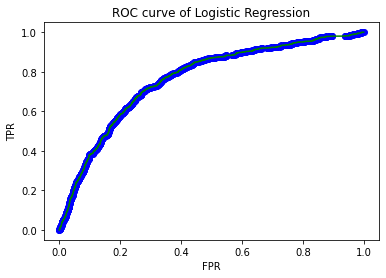

In [ ]:
y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve of Logistic Regression')
plt.xlabel('FPR')
plt.ylabel('TPR')



* 정확도:0.71, 정밀도:0.71,0.72, 재현율: 0.73,0.70, AUC:0.771


**Decision Tree**(Tree-based Model)

In [ ]:
pipe1 = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe1.fit(X_train, y_train)
print('검증 정확도: ', pipe1.score(X_val, y_val))

검증 정확도:  0.7622036262203626


Text(0.5, 1.0, 'Confusion matrix, n = 5736')

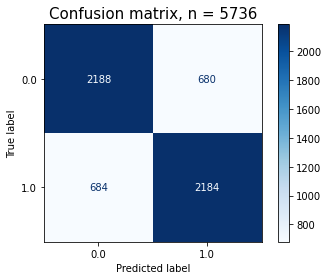

In [ ]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe1, X_val, y_val,
                            cmap=plt.cm.Blues,
                            values_format='d',
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

In [ ]:
y_pred = pipe1.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76      2868
         1.0       0.76      0.76      0.76      2868

    accuracy                           0.76      5736
   macro avg       0.76      0.76      0.76      5736
weighted avg       0.76      0.76      0.76      5736



AUC score:  0.7992413521783193


Text(0, 0.5, 'TPR')

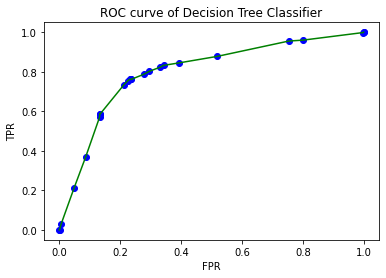

In [ ]:
y_pred_proba = pipe1.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve of Decision Tree Classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')

* 정확도:0.77, 정밀도:0.77,0.76, 재현율: 0.76,0.77, AUC:0.799

**Random Forest**(Ensemble Model)

In [ ]:
pipe2 = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=500, criterion="entropy", max_depth=10, max_features=0.25, oob_score=True, n_jobs=-1, random_state=10)
)

pipe2.fit(X_train, y_train)
print('검증 정확도: ', pipe2.score(X_val, y_val))

검증 정확도:  0.7768479776847977


Text(0.5, 1.0, 'Confusion matrix, n = 5736')

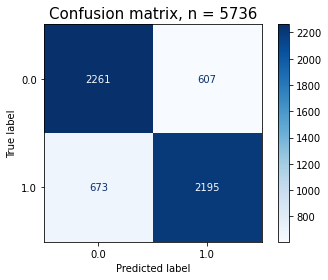

In [ ]:
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe2, X_val, y_val,
                            cmap=plt.cm.Blues,
                            values_format='d',
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)

In [ ]:
y_pred = pipe2.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78      2868
         1.0       0.78      0.77      0.77      2868

    accuracy                           0.78      5736
   macro avg       0.78      0.78      0.78      5736
weighted avg       0.78      0.78      0.78      5736



AUC score:  0.8098011725596151


Text(0, 0.5, 'TPR')

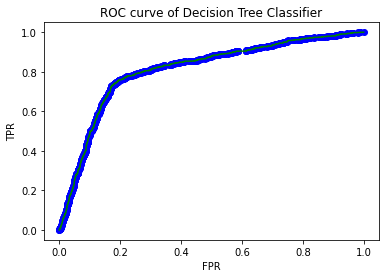

In [ ]:
y_pred_proba = pipe2.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve of Decision Tree Classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')

* 정확도:0.77, 정밀도:0.75,0.80, 재현율: 0.81,0.74, AUC:0.806

**XGBoost**(Ensemble Model)

In [ ]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

model = XGBClassifier(
    n_estimators=1000,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=7,        # default=3, high cardinality 특성을 위해 기본보다 높여 보았습니다.
    learning_rate=0.2,
#     scale_pos_weight=ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=10
         ) # 10 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-error:0.224876	validation_1-error:0.236925
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.2191	validation_1-error:0.221409
[2]	validation_0-error:0.216581	validation_1-error:0.227336
[3]	validation_0-error:0.217059	validation_1-error:0.224547
[4]	validation_0-error:0.214062	validation_1-error:0.223501
[5]	validation_0-error:0.213889	validation_1-error:0.22106
[6]	validation_0-error:0.211196	validation_1-error:0.219142
[7]	validation_0-error:0.209459	validation_1-error:0.219665
[8]	validation_0-error:0.206115	validation_1-error:0.218968
[9]	validation_0-error:0.20555	validation_1-error:0.221932
[10]	validation_0-error:0.203639	validation_1-error:0.21984
[11]	validation_0-error:0.20238	validation_1-error:0.220537
[12]	validation_0-error:0.20086	validation_1-error:0.221932
[13]	validation_0-error:0.200599	validation_1-error:0.220886
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

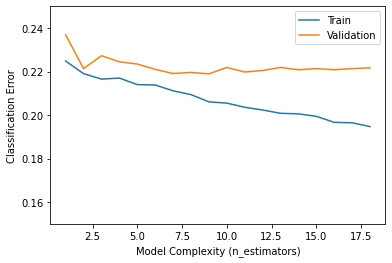

In [ ]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.15, 0.25)) # Zoom in
plt.legend();

In [ ]:
print('검증 정확도', model.score(X_val_encoded, y_val))
y_pred = model.predict(X_val_encoded)
print(classification_report(y_val, y_pred))

검증 정확도 0.7810320781032078
              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79      2868
         1.0       0.80      0.75      0.78      2868

    accuracy                           0.78      5736
   macro avg       0.78      0.78      0.78      5736
weighted avg       0.78      0.78      0.78      5736



AUC score:  0.8151382226618349


Text(0, 0.5, 'TPR')

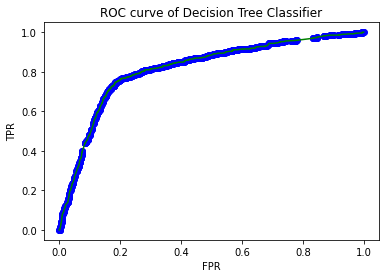

In [ ]:
y_pred_proba = model.predict_proba(X_val_encoded)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve of Decision Tree Classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')

* 정확도:0.78, 정밀도:0.75,0.80, 재현율: 0.82,0.73, AUC:0.802

**하이퍼 파라미터 튜닝**

In [ ]:
# X = pd.concat([X_train, X_val])
# y = pd.concat([y_train, y_val])
# encoder1 = OrdinalEncoder()
# X_encoded1 = encoder1.fit_transform(X) # 학습데이터

# model1 = XGBClassifier()
# n_estimators = [50, 100, 150, 200]
# max_depth = [2, 4, 6, 8]
# learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
# param_grid = dict(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
# grid_search = GridSearchCV(model1, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold, verbose=1)
# grid_result = grid_search.fit(X_encoded1, y)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#   print("%f (%f) with: %r" % (mean, stdev, param))
  



*   Best -  점수(Accuracy):0.892339, learning_rate:0.3, max_depth: 8, n_estimators: 200



**하이퍼 파라미터 튜닝을 통해 얻은 값으로 모델링**

In [ ]:
encoder2 = OrdinalEncoder()
X_train_encoded2 = encoder2.fit_transform(X_train) # 학습데이터
X_val_encoded2 = encoder2.transform(X_val) # 검증데이터

model2 = XGBClassifier(
    n_estimators=200,  
    max_depth=8,       
    learning_rate=0.3,
    n_jobs=-1
)

eval_set = [(X_train_encoded2, y_train), 
            (X_val_encoded2, y_val)]

model2.fit(X_train_encoded2, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 10 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-error:0.214193	validation_1-error:0.239365
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.206723	validation_1-error:0.233089
[2]	validation_0-error:0.202727	validation_1-error:0.224024
[3]	validation_0-error:0.198515	validation_1-error:0.226464
[4]	validation_0-error:0.197168	validation_1-error:0.228731
[5]	validation_0-error:0.193347	validation_1-error:0.229079
[6]	validation_0-error:0.188787	validation_1-error:0.229254
[7]	validation_0-error:0.183445	validation_1-error:0.226116
[8]	validation_0-error:0.180361	validation_1-error:0.229777
[9]	validation_0-error:0.177886	validation_1-error:0.230823
[10]	validation_0-error:0.176496	validation_1-error:0.230474
[11]	validation_0-error:0.173934	validation_1-error:0.232043
[12]	validation_0-error:0.173239	validation_1-error:0.23152
[13]	validation_0-error:0.168505	validation_1-error:0.230

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

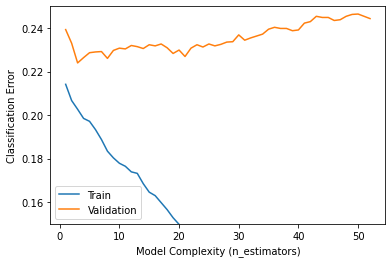

In [ ]:
results = model2.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.15, 0.25)) # Zoom in
plt.legend();

*   검증곡선을 그려서 최적화된 지점을 찾았다. 검증곡선과 훈련곡선의 차이가 벌어지기 시작하는 지점으로 값을 설정해야 그 이상으로 일어나는 과적합을 막고 일반화 성능을 지킬 수 있다.
*   이 지점이 과소적합과 과적합 사이에 모델이 가장 일반화가 잘 되면서 성능이 좋은 최적화된 지점이다.
*   최적화된 n_estimators는 2이다.



In [ ]:
print('검증 정확도', model.score(X_val_encoded2, y_val))
y_pred = model2.predict(X_val_encoded2)
print(classification_report(y_val, y_pred))

검증 정확도 0.7810320781032078
              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78      2868
         1.0       0.79      0.75      0.77      2868

    accuracy                           0.78      5736
   macro avg       0.78      0.78      0.78      5736
weighted avg       0.78      0.78      0.78      5736



AUC score:  0.8067990172907804


Text(0, 0.5, 'TPR')

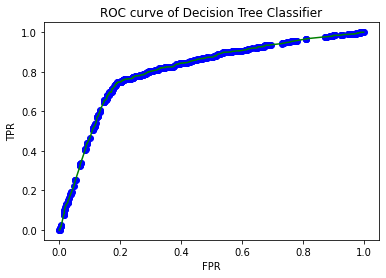

In [ ]:
y_pred_proba = model2.predict_proba(X_val_encoded2)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve of Decision Tree Classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')



* 정확도:0.78, 정밀도:0.75,0.79, 재현율: 0.80,0.75, AUC:0.807



**최종 모델**(n_estimators = 2)

In [ ]:
encoder3 = OrdinalEncoder()
X_train_encoded3 = encoder3.fit_transform(X_train) # 학습데이터
X_val_encoded3 = encoder3.transform(X_val) #테스트 데이터
X_train_encoded3 = pd.DataFrame(X_train_encoded3, columns=['city_development_index','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job',\
                                                           'training_hours'])
X_val_encoded3 = pd.DataFrame(X_val_encoded3, columns=['city_development_index','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job',\
                                                           'training_hours'])
Series.to_frame(y_train, name='target')
Series.to_frame(y_val, name='target')

model3 = XGBClassifier(
    n_estimators=2,  
    max_depth=8,       
    learning_rate=0.3,
    n_jobs=-1
)

eval_set = [(X_train_encoded3, y_train), 
            (X_val_encoded3, y_val)]

model3.fit(X_train_encoded3, y_train, 
          eval_set=eval_set,
          eval_metric='auc', 
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

[0]	validation_0-auc:0.83613	validation_1-auc:0.792778
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.847351	validation_1-auc:0.801477


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=2, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
print('검증 정확도', model3.score(X_val_encoded3, y_val))
y_pred = model3.predict(X_val_encoded3)
print(classification_report(y_val, y_pred))

검증 정확도 0.7669107391910739
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77      2868
         1.0       0.78      0.74      0.76      2868

    accuracy                           0.77      5736
   macro avg       0.77      0.77      0.77      5736
weighted avg       0.77      0.77      0.77      5736



AUC score:  0.8014768600378535


Text(0, 0.5, 'TPR')

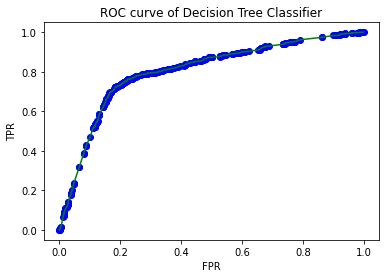

In [ ]:
y_pred_proba = model3.predict_proba(X_val_encoded3)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve of Decision Tree Classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')

* 정확도:0.77, 정밀도:0.75,0.78, 재현율: 0.79,0.74, AUC:0.801

**Test Score**

In [ ]:
X_test_encoded = encoder3.transform(X_test)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=['city_development_index','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job',\
                                                           'training_hours'])
y_test = pd.DataFrame(y_test, columns=['target'])
y_pred = model3.predict(X_test_encoded)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84      1553
         1.0       0.56      0.71      0.63       576

    accuracy                           0.77      2129
   macro avg       0.72      0.75      0.73      2129
weighted avg       0.80      0.77      0.78      2129



AUC score:  0.7871793839879803


Text(0, 0.5, 'TPR')

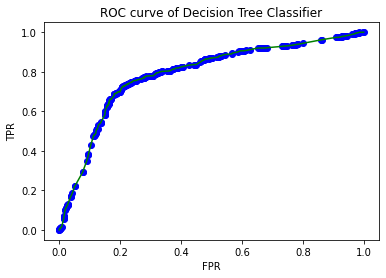

In [ ]:
y_pred_proba = model3.predict_proba(X_test_encoded)[:, -1]
print('AUC score: ', roc_auc_score(y_test, y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve of Decision Tree Classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')

* **Test Score** 정확도:0.77, 정밀도:0.88,0.56, 재현율: 0.80,0.71, AUC:0.787

# **머신러닝 모델 해석**

In [ ]:
# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
plt.rcParams['figure.dpi'] = 144
plt.rcParams['axes.grid'] = False


In [ ]:
encoder3.mapping

AttributeError: ignored

<Figure size 1152x864 with 0 Axes>

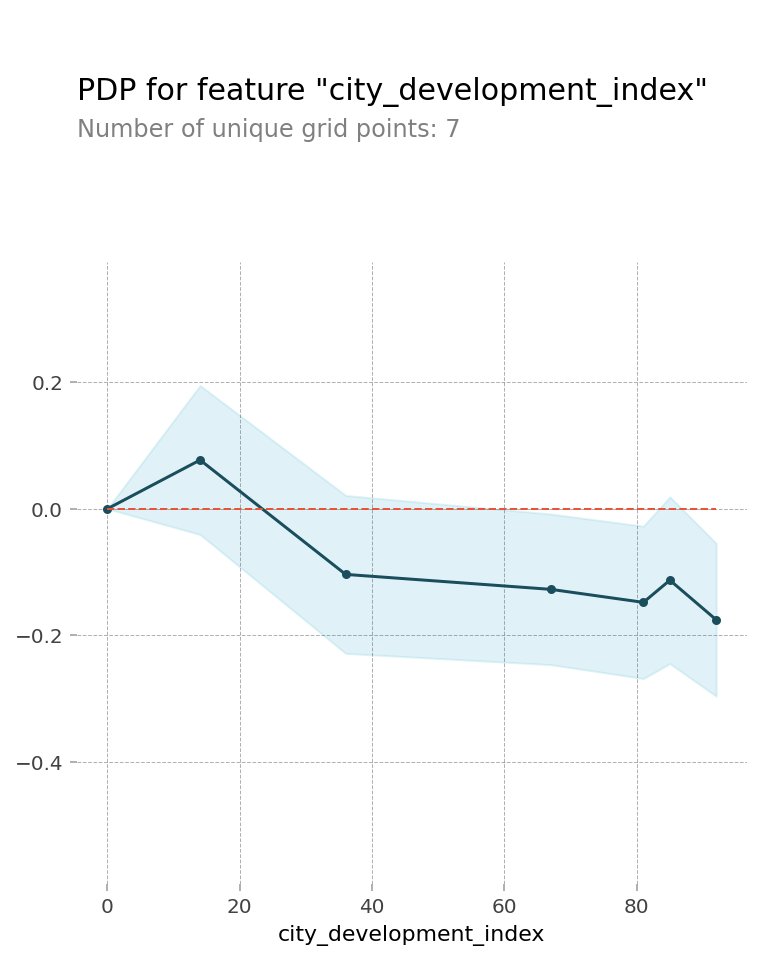

In [ ]:
plt.figure(figsize=(8, 6))
feature = 'city_development_index'
isolated = pdp_isolate(
      model=model3, 
      dataset=X_train_encoded3, 
      model_features=X_train_encoded3.columns, 
      feature= feature
  )
pdp_plot(isolated, figsize=(6,8), feature_name=feature);

In [ ]:
gbm = XGBClassifier(n_estimators=2,  
    max_depth=8,       
    learning_rate=0.3,
    n_jobs=-1).fit(X_train_encoded3, y_train)

In [ ]:
train_upsampled['target'].dtypes

dtype('float64')

In [ ]:
train_up_encoded = encoder3.fit_transform(train_upsampled)
fig, axes, summary_df = info_plots.target_plot(
df=train_up_encoded, feature='gender', feature_name='gender', target='target')


AttributeError: ignored

In [ ]:
X_val_encoded3.shape

(5736, 11)

In [ ]:
X = X_train_encoded3
y = y_train
model = model3
%pylab inline
fig = plt.figure(figsize(10, 9))
plot_partial_dependence(model, X, ['gender'], fig=fig)
plt.show()

Populating the interactive namespace from numpy and matplotlib


ValueError: ignored

<Figure size 720x648 with 0 Axes>

In [ ]:
#['city_development_index','gender','relevent_experience','enrolled_university','education_level','major_discipline','experience','company_size','company_type','last_new_job','training_hours']
feature = 'gender'
isolated = pdp_isolate(
model=model3, 
dataset= X_val, 
model_features= X_val.columns, 
feature= feature
)
pdp_plot(isolated, feature_name=feature);

TypeError: ignored

In [ ]:
# encoder = OrdinalEncoder()
# X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
# X_val_encoded = encoder.transform(X_val) # 검증데이터

# model = XGBClassifier()

# depth = range(1, 30, 2)
# ts, vs = validation_curve(
#     model, X_train_encoded, y_train
#     , param_name='xgbclassifier__max_depth'
#     , param_range=depth, scoring='accuracy'
#     , cv=3
#     , n_jobs=-1
# )

# train_scores_mean = np.mean(ts, axis=1)
# validation_scores_mean = np.mean(vs, axis=1)

# fig, ax = plt.subplots()

# # 훈련세트 검증곡선
# ax.plot(depth, train_scores_mean, label='training accuracy')


# # 검증세트 검증곡선
# ax.plot(depth, validation_scores_mean, label='validation accuracy')

# # 이상적인 max_depth
# #ax.vlines(5,0, train_scores_mean.max(), color='blue')

# # 그래프 셋팅
# ax.set(title='Validation Curve'
#       , xlabel='Model Complexity(max_depth)', ylabel='Accuracy')
# ax.legend()
# fig.dpi = 100

In [ ]:
# #city 특성이 high cardinality인데 어짜피 어떤 도시인지 모르므로 중요하지 않다고 생각되어 드랍한다.
# y_train = train.target
# X_train = train.drop(['target','city'], axis=1)

# pipe = make_pipeline(
#     OrdinalEncoder(), 
#     LogisticRegression()
# )

# pipe.fit(X_train, y_train)

# pred_y_0 = pipe.predict(X_train)
# print(np.unique(pred_y_0))

# print(accuracy_score(pred_y_0, y_train))
# #train 데이터로 로지스틱 리그레션 모델을 돌렸을 때 accuracy 값이 0.767 나왔다.

In [ ]:
# def evaluate(model, X, y):
#     predictions = model.predict(X)
#     accuracy = accuracy_score(predictions, y)
#     tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
#     sensitivity = tp / (tp+fn)
#     specificity = tn / (tn+fp)
#     auc = roc_auc_score(y, predictions)
    
#     print("AUC: ", auc)
#     print("Sensitivity: ", round(sensitivity,2)) #1의 값을 예측한 정도
#     print("Specificity: ", round(specificity,2)) #0의 값을 예측한 정도

#     return round(accuracy,2)


In [ ]:
# evaluate(pipe, X_train, y_train)

In [ ]:
# train.target.value_counts(normalize=True)

In [ ]:
# # Resampel function으로 인해 데이터가 balanced 된것을 확인합니다. 
# df_upsampled.target.value_counts()

In [ ]:
# y = df_upsampled.target
# X = df_upsampled.drop(['target','city'], axis=1)
# pipe_up = make_pipeline(
#     OrdinalEncoder(), 
#     LogisticRegression()
# )
# pipe_up.fit(X, y)

# pred_y_1 = pipe_up.predict(X)
# print(np.unique(pred_y_1))
# print(accuracy_score(y, pred_y_1))

In [ ]:
# evaluate(pipe, X_train, y_train)

In [ ]:
# evaluate(pipe_up, X, y)

* 데이터 불균형을 해결함으로써 1의값을 예측하는 정도와 0의 값을 예측하는 정도가 비슷하게 맞춰진 것을 알 수 있다.
* AUC 값도 0.6에 비해 더 높은 0.7이라는 결과가 나왔다.